In [1]:
import sys
import gc
import os
import warnings

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# progress bar
from tqdm import tqdm

#tensorflow based modul
import tensorflow as tf
import keras
from keras import backend as K
warnings.filterwarnings(action='ignore')

K.image_data_format()

print ('Python version ->', sys.version)
print ('Numpy version ->', np.__version__)
print ('Pandas version ->', pd.__version__)
print ('Tensorflow version ->', tf.VERSION)
print ('Keras version ->', keras.__version__)

Python version -> 3.6.6 |Anaconda, Inc.| (default, Oct  9 2018, 12:34:16) 
[GCC 7.3.0]
Numpy version -> 1.16.4
Pandas version -> 0.23.4
Tensorflow version -> 1.14.0
Keras version -> 2.2.4


Using TensorFlow backend.


# 1. Data Set Loading
### **참고** 
* [[3rd ML Month]Car Model Classification Baseline](https://www.kaggle.com/fulrose/3rd-ml-month-car-model-classification-baseline) 
* [[3rd ML Month]Car Image Cropping](https://www.kaggle.com/tmheo74/3rd-ml-month-car-image-cropping)

* [Keras, How to use pretrained model?](https://www.kaggle.com/daehungwak/keras-how-to-use-pretrained-model)

In [2]:
DATA_PATH = '../input/'
os.listdir(DATA_PATH)

['train',
 'train.csv',
 'sample_submission.csv',
 'class.csv',
 'test',
 'test.csv']

Data Description
* train.csv - Train 셋의 이미지 파일명, 바운딩박스 좌표, 차종정보
* test.csv - Test 셋의 이미지 파일명, 바운딩박스 좌표, 차종정보
* submission.csv - Test셋과 대응되는 제출 파일
* class.csv - 데이터 셋의 class 컬럼과 대응되는 차종의 레이블
* train - Train 이미지 파일
* test - Test 이미지 파일

In [3]:
# 이미지 폴더 경로
TRAIN_IMG_PATH = os.path.join(DATA_PATH, 'train')
TEST_IMG_PATH = os.path.join(DATA_PATH, 'test')

# crop 이미지 폴더 경로
TRAIN_CROP_PATH = './train_crop'
TEST_CROP_PATH = "./test_crop"

# CSV 파일 경로
train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
data_class = pd.read_csv(os.path.join(DATA_PATH, 'class.csv'))

# 2. EDA (Exploratory Data Analysis)

#### Data Description

* img_file - 데이터 셋의 각 로우와 연결되는 이미지 파일 이름
* bbox_x1 - 바운딩 박스 x1 좌표 (좌상단 x)
* bbox_y1 - 바운딩 박스 y1 좌표 (좌상단 y)
* bbox_x2 - 바운딩 박스 x2 좌표 (우하단 x)
* bbox_y2 - 바운딩 박스 y2 좌표 (우하단 y)
* class - 예측하려는 차종(Target)
* id - 각 데이터 셋에 기입 되어 있는 클래스 id
* name - 클래스 id에 대응되는 실제 차종 레이블

In [4]:
train.head()

,img_file,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class
0,train_00001.jpg,1,80,641,461,108
1,train_00002.jpg,57,53,293,236,71
2,train_00003.jpg,35,42,227,160,76
3,train_00004.jpg,10,21,254,165,188
4,train_00005.jpg,1,67,772,573,44


In [5]:
test.head()

,img_file,bbox_x1,bbox_y1,bbox_x2,bbox_y2
0,test_00001.jpg,199,184,1116,809
1,test_00002.jpg,55,61,480,257
2,test_00003.jpg,42,123,602,413
3,test_00004.jpg,13,8,619,393
4,test_00005.jpg,8,9,209,93


In [6]:
# Data 누락 체크
if set(list(train.img_file)) == set(os.listdir(TRAIN_IMG_PATH)) :
    print("Train image file 누락 없음!")
else : 
    print("Train image file 누락")

if set(list(test.img_file)) == set(os.listdir(TEST_IMG_PATH)) :
    print("Test image file 누락 없음!")
else : 
    print("Test image file 누락")

Train image file 누락 없음!
Test image file 누락 없음!


In [7]:
# Data 갯수
print("Number of Train Data : {}".format(train.shape[0]))
print("Number of Test Data : {}".format(test.shape[0]))

Number of Train Data : 9990
Number of Test Data : 6150


In [8]:
data_class.head()

,id,name
0,1,AM General Hummer SUV 2000
1,2,Acura RL Sedan 2012
2,3,Acura TL Sedan 2012
3,4,Acura TL Type-S 2008
4,5,Acura TSX Sedan 2012


### Class Distribution

분류문제에서 확인해봐야할 부분이 Target Variable의 분포를 확인하여 밸런스 파악


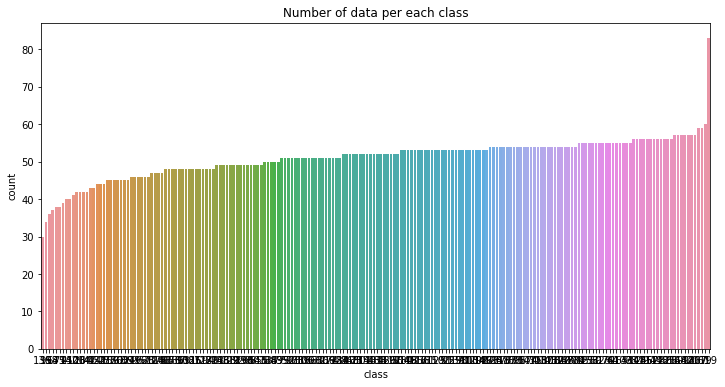

In [9]:
plt.figure(figsize=(12,6))
sns.countplot(train["class"], order=train["class"].value_counts(ascending=True).index)
plt.title("Number of data per each class")
plt.show()

In [10]:
cntEachClass = train["class"].value_counts(ascending=False)
print("Class with most count  : {}".format(cntEachClass.index[0]))
print("Most Count : {}".format(cntEachClass.max()))

print("Class with fewest count  : {}".format(cntEachClass.index[-1]))
print("Fewest Count : {}".format(cntEachClass.min()))

print("Mean  : {}".format(cntEachClass.mean()))

Class with most count  : 119
Most Count : 83
Class with fewest count  : 136
Fewest Count : 30
Mean  : 50.96938775510204


가장 많이 분포되어 있는 class는 119이며, 84개의 데이터가 존재

가장 적게 분포되어 있는 class는 136이며, 30개의 데이터가 존재한다.

### Image Visualization

파이썬 커널에서 이미지를 로드하는 방법은 PIL라이브러리를 사용한다.
Documentation : https://pillow.readthedocs.io/en/stable/

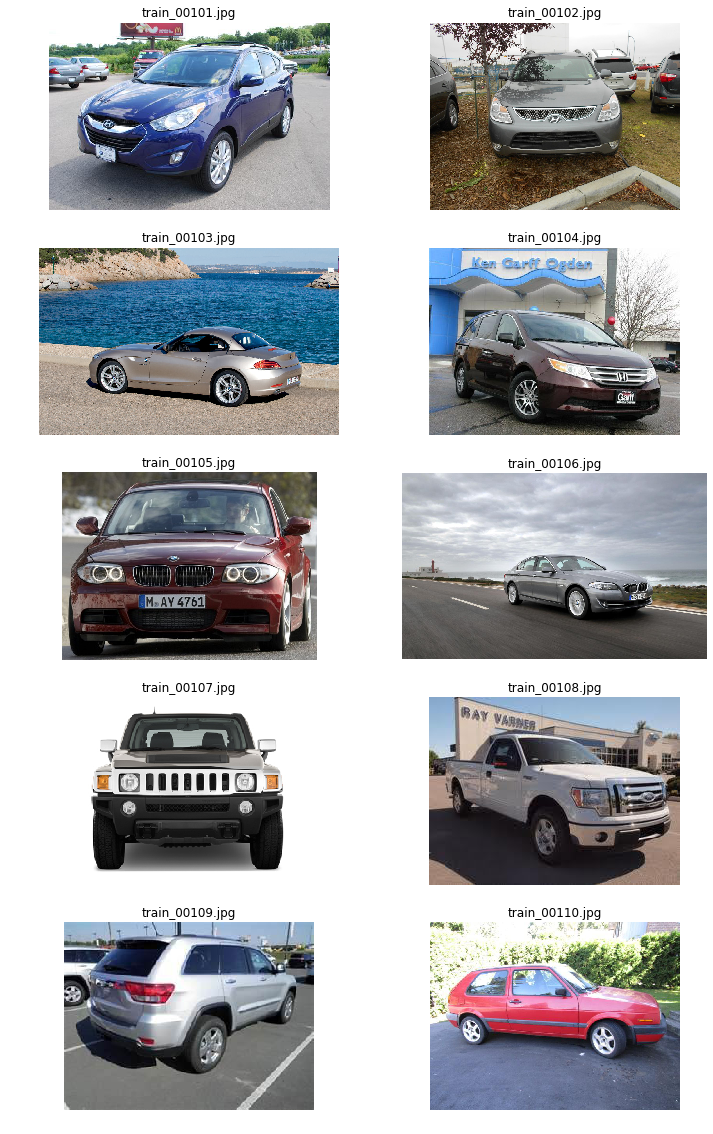

In [11]:
import PIL
from PIL import ImageDraw

tmp_imgs = train['img_file'][100:110] # image file name
plt.figure(figsize=(12,20))

for num, f_name in enumerate(tmp_imgs):
    #경로상에 있는 image파일을 불러옴
    img = PIL.Image.open(os.path.join(TRAIN_IMG_PATH, f_name))
    
    # 5,2 행렬, 첫 번째 plot은 1
    plt.subplot(5, 2, num + 1)
    plt.title(f_name)
    plt.imshow(img)
    plt.axis('off')

### Bounding Box

바운딩 박스란?<br/>
이미지 내부에서 특정 Object를 박스로 레이블한 좌표를 말하며, 보통 좌측 상단 (x1, y1)과, 우측 하단 (x2, y2) 좌표가 주어져서
직사각형 모양의 박스를 그릴 수 있게됩니다. 이때, 좌표는 이미지의 픽셀 좌표입니다.

In [12]:
# \은 한 줄씩 해석하는 인터프리터언어를 여러줄에 걸쳐 해석하기 위함 (여기선 안써도됌)
# original image에서 bounding box 좌표를 활용하여 학습에 필요한 부분 표시하기

def draw_rect(drawcontext, pos, outline=None, width = 0):
    (x1, y1) = (pos[0], pos[1])
    (x2, y2) = (pos[2], pos[3])
    points = (x1, y1), (x2, y1), (x2, y2), (x1, y2), (x1, y1)
    drawcontext.line(points, fill = outline, width = width)
    
def make_boxing_img(img_name) : 
    if img_name.split('_')[0] == 'train' :
        PATH = TRAIN_IMG_PATH
        data = train
    elif img_name.split('_')[0] == 'test' :
        PATH = TEST_IMG_PATH
        data = test
        
    img = PIL.Image.open(os.path.join(PATH, img_name))
    pos = data.loc[data['img_file'] == img_name, 
                   ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2']].values.reshape(-1)
    draw = ImageDraw.Draw(img)
    draw_rect(draw, pos, outline='red', width = 10)
        
    return img

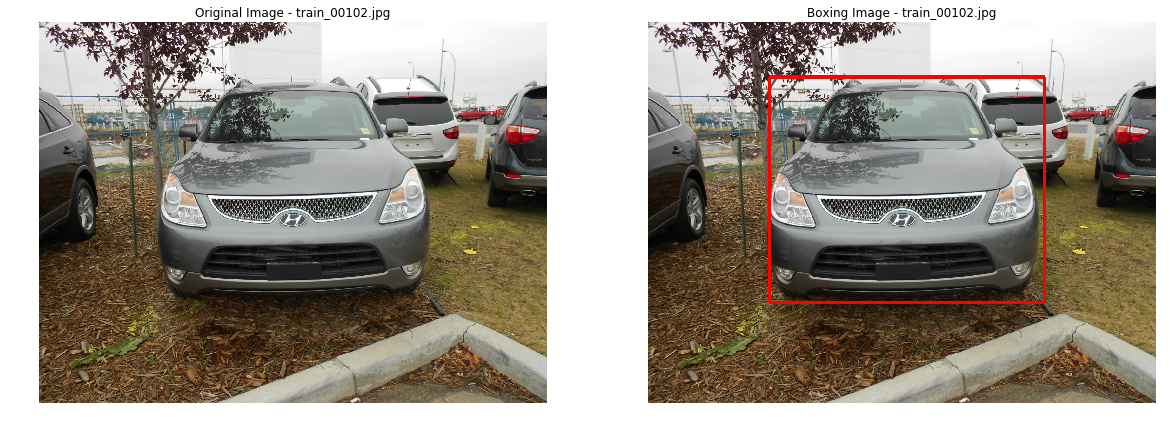

In [13]:
f_name = "train_00102.jpg"

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
# Original Image
origin_img = PIL.Image.open(os.path.join(TRAIN_IMG_PATH, f_name))
plt.title("Original Image - {}".format(f_name))
plt.imshow(origin_img)
plt.axis('off')

# Image included bounding box
plt.subplot(1, 2, 2)
boxing = make_boxing_img(f_name)
plt.title("Boxing Image - {}".format(f_name))
plt.imshow(boxing)
plt.axis('off')

plt.show()

왼쪽그림과 같이 Target object뿐만 아니라 상관없는 다른 object(noise)가 섞여 있을 수 있다. 이런 경우에 이미지 내부에서 필요한 Object를 명확히 표시하기 위해 Bounding Box를 사용한다.<br/>(실제로 이미지를 모델에 넣을때는 Box 바깥 부분은 잘라서 사용.)

만약 Bounding Box 좌표가 주어지지 않는다면 직접 레이블을 하거나, Bounding Box 좌표를 예측하는 딥러닝 모델을 설계해볼수도있다.<br/>

## 3. Cropped Image Dataset

In [14]:
def crop_resize_boxing_img(img_name, margin=16, size=(224, 224)): 
    if img_name.split('_')[0] == 'train' :
        PATH = TRAIN_IMG_PATH
        data = train
    elif img_name.split('_')[0] == 'test' :
        PATH = TEST_IMG_PATH
        data = test
        
    img = PIL.Image.open(os.path.join(PATH, img_name))
    pos = data.loc[data['img_file'] == img_name, 
                   ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2']].values.reshape(-1)
    
    width, height = img.size
    x1 = max(0, pos[0] - margin)
    y1 = max(0, pos[1] - margin)
    x2 = min(pos[2] + margin, width)
    y2 = min(pos[3] + margin, height)
    
    return img.crop((x1, y1, x2, y2)).resize(size)

### 3.1 Process Train, Test Image Data Crop

In [15]:
!mkdir {TRAIN_CROP_PATH}

In [16]:
%%time
for i, row in train.iterrows():
    cropped = crop_resize_boxing_img(row['img_file'])
    cropped.save(f"{TRAIN_CROP_PATH}/{row['img_file']}")

CPU times: user 2min 16s, sys: 3.96 s, total: 2min 20s
Wall time: 2min 31s


In [17]:
!mkdir {TEST_CROP_PATH}

In [18]:
%%time
for i, row in test.iterrows():
    cropped = crop_resize_boxing_img(row['img_file'])
    cropped.save(f"{TEST_CROP_PATH}/{row['img_file']}")

CPU times: user 1min 22s, sys: 2.26 s, total: 1min 24s
Wall time: 1min 31s


#### Cropped Image Eye Checking

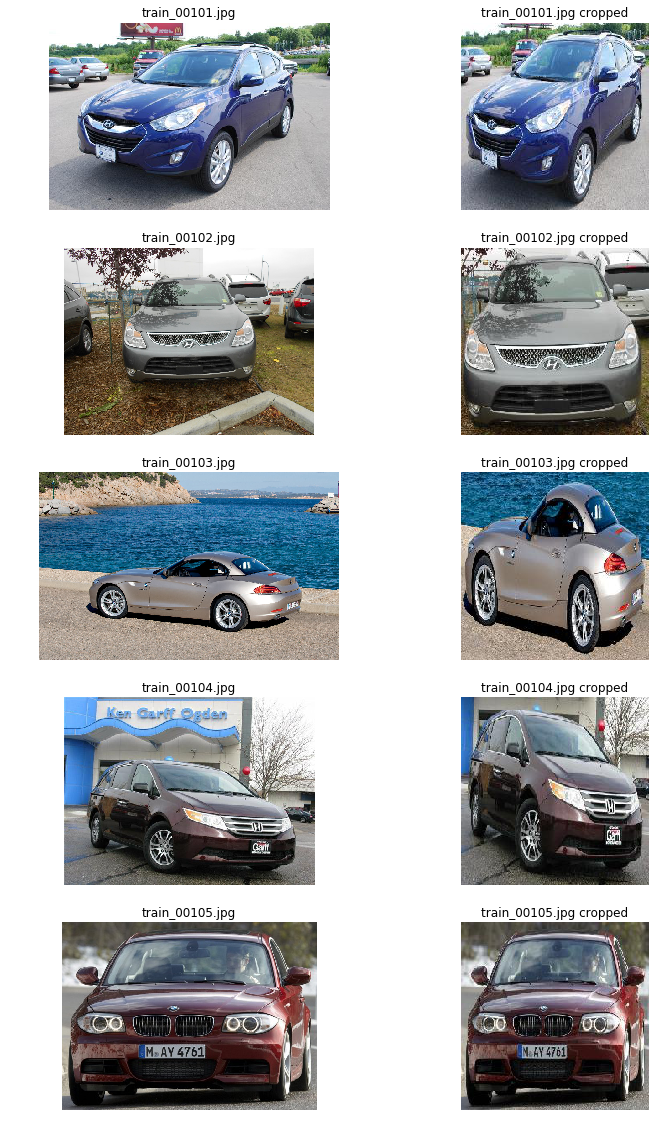

In [19]:
import PIL
from PIL import ImageDraw

tmp_imgs = train['img_file'][100:105] # image file name
plt.figure(figsize=(12,20))

for num, f_name in enumerate(tmp_imgs):
    #경로상에 있는 image파일을 불러옴
    img = PIL.Image.open(os.path.join(TRAIN_IMG_PATH, f_name))
    
    # 5,2 행렬, 첫 번째 plot은 1
    plt.subplot(5, 2, 2*num + 1)
    plt.title(f_name)
    plt.imshow(img)
    plt.axis('off')
    
    img_crop = PIL.Image.open(f"train_crop/{f_name}")
    plt.subplot(5, 2, 2*num + 2)
    plt.title(f_name + ' cropped')
    plt.imshow(img_crop)
    plt.axis('off')

# 4. Modeling

In [20]:
train["class"] = train["class"].astype('str')
train = train[['img_file', 'class']]
test = test[['img_file']]

In [21]:
model_path = '../model/'
if not os.path.exists(model_path):
    os.mkdir(model_path)

In [22]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

def get_callback(model_name, patient):
    es = EarlyStopping(monitor = 'val_loss', patience = patient, verbose = 1, mode= 'min')
    Reduce = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patient = patient/2, min_lr = 0.000001, verbose=1, mode='min')
    ckpt = ModelCheckpoint(filepath = model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

    return [ckpt, es, Reduce]

In [24]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, GlobalAveragePooling2D
from keras import optimizers

def get_model(model_name, image_size=299):
    base_model = model_name(weights='imagenet', input_shape=(image_size, image_size, 3), include_top = False)
    
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(2048, activation='relu', kernel_initializer = 'he_normal'))
    model.add(Dropout(0.15))
    model.add(Dense(196, activation='softmax', kernel_initializer = 'lecun_normal'))
    model.summary()
    
    optimizer = optimizers.Nadam(lr=0.0002)
    model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics=['acc'])
    
    return model

#### Generator
참고한 커널에서 작성자가 중요하다고 생각하는 것, 이미지프로세싱에서 필수과정
#### Generator이란?
코랩이나 캐글 커널같은 클라우드 환경 또는 일반적인 로컬 환겨에서 정말 유용하게 사용됨. 이유는 이러한 환경은 메모리가 충분하지 않기 때문이다. 특히나 이미지처럼 파일하나의 용량이 매우 큰 경우, 한번에 모든 파일을 메모리에 적재하면 상당히 큰 부담이 된다. 배치사이즈 단위 만큼 파일을 불러와 학습하고 끝나면 다시 불러와서 학습하는 방법을 반복하기 때문에 전체 핛브을 하더라도 메모리를 조금만 사용하게 된다.

그렇다면... 시간은 조금 더 걸리겠지?
#### Keras DataGenerator
케라스에는 제너레이터 함수가 존재. 케라스 ImageDataGenerator는 제너레이터의 기능은 물론 제너레이터를 정의하면서 동시에 Data에 원하는 Noise까지 부여가능하다. 또한 Documentation을 참고하부여가능하다. 또한 Documentation을 참고하면 새 많은 기능이 있어 한 번 볼것

Documentaion : https://keras.io/preprocessing/image/

In [25]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [27]:
#model
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.applications import Xception

#generator
from keras.preprocessing.image import ImageDataGenerator

# Parameter
img_size = (299, 299)
epochs = 100
batch_size = 32

# Define Generator config
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=20,
    width_shift_range = 0.2,
    height_shift_range=0.2,
    horizontal_flip = True,
    vertical_flip =False,
    zoom_range = 0.3,
    shear_range=0.5,
    brightness_range=[0.5, 1.5],
    fill_mode='nearest',
    preprocessing_function = get_random_eraser(v_l = 0, v_h = 255)
)

val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)



* MobileNet : 모델이 가볍고 빠르게 학습되서, 테스트에 용이해 많이 사용한다. 모델을 교체하며 가장 좋은 아키텍쳐를 찾는 작업도 좋은 스코어를 얻는데 좋다.
* ResNet50(Loading Pretrained Model) : Residual(잔차)를 이용한 획기적인 모델로 평가한다. 보통 딥러닝 모델 구성할 때 직접 만드는 것도 좋지만, 상당히 많은 시간과 노력이 필요하여 성능이 입증된 모델을 불러서 사용한다.
* EfficientNet : 
* Xception

Pretrained Model을 불러오기 위해서는 커널의 Internet 옵션이 활성화 되어 있어야 한다.

ResNet arxiv : http://www.arxiv.org/abs/1512.03385

cross-validation을 활용하여 학습 테스트

여기서는 StratifiedKFold를 활용한다.
이것은 각 클래스별 훈련데이터의 분포가 다르니 각 클래스 분포에 맞춰서 폴드를 나누게 된다. (각 클래스별 샘플 수 의 비율을 유지하면서 Fold를 나누기 위함.)

In [28]:
from sklearn.model_selection import StratifiedKFold

k_folds = 5

skf = StratifiedKFold(n_splits=k_folds, random_state=42)

In [29]:
%%time

j = 1
model_xception_names = []
for (train_index, valid_index) in skf.split(train['img_file'],train['class']):
    
    traindf = train.iloc[train_index, :].reset_index().drop('index', axis = 1)
    validdf = train.iloc[valid_index, :].reset_index().drop('index', axis = 1)
    
    print("=========================================")
    print("====== K Fold Validation step => %d/%d =======" % (j,k_folds))
    print("=========================================")
    
    # Make Generator
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=traindf,
        directory= TRAIN_CROP_PATH,
        x_col='img_file',
        y_col='class',
        target_size = img_size,
        color_mode='rgb',
        class_mode='categorical',
        batch_size = batch_size,
        seed=42,
        shuffle = True
        )

    validation_generator = val_datagen.flow_from_dataframe(
        dataframe= validdf,
        directory= TRAIN_CROP_PATH,
        x_col='img_file',
        y_col='class',
        target_size = img_size,
        color_mode='rgb',
        class_mode='categorical',
        batch_size = batch_size,
        shuffle=True
        )
    
    model_name = model_path + str(j) + '_xception.hdf5'
    model_xception_names.append(model_name)
    
    model_xception = get_model(Xception, 299)
    
    try:
        model_xception.load_weights(model_name)
    except:
        pass
    
    history = model_xception.fit_generator(
        train_generator,
        steps_per_epoch = len(traindf.index) / batch_size,
        epochs = epochs,
        validation_data = validation_generator,
        validation_steps = len(validdf.index) / batch_size,
        callbacks = get_callback(model_name, 6),
        verbose=1
        )    
    
    j+=1

====== K Fold Validation step => 1/5 =======
Found 7914 validated image filenames belonging to 196 classes.
Found 2076 validated image filenames belonging to 196 classes.
83689472/83683744 [==============================] - 3s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 196)               401604    
Total params: 25,459,436
Trainable par

5개의 Fold를 훈련하면서 각 폴드별 Val loss가 가장 작은 model weight를 저장한다.

훈련이 끝나면 5개의 Weight파일이 생성된다.

자원이 되면 여기에 xception 이외에 다른 사전 훈련 모델을 하나 더 추가하고, 나중에 그 모델까지 통합하여 앙상블 해도 될 듯 하다.

In [30]:
%%time

test_generator = test_datagen.flow_from_dataframe(
    dataframe= test,
    directory= TEST_CROP_PATH,
    x_col='img_file',
    y_col=None,
    target_size = img_size,
    color_mode='rgb',
    class_mode=None,
    batch_size = batch_size,
    shuffle=False
)

Found 6150 validated image filenames.
CPU times: user 48 ms, sys: 16 ms, total: 64 ms
Wall time: 89.6 ms


In [31]:
xception_prediction = []
for i, name in enumerate(model_xception_names):
    model_xception = get_model(Xception, 299)
    model_xception.load_weights(name)
    test_generator.reset()
    pred = model_xception.predict_generator(
        generator = test_generator,
        steps = len(test)/batch_size,\
        verbose = 1
    )
    xception_prediction.append(pred)
    
y_pred_xception = np.mean(xception_prediction, axis = 0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 2048)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dropout_6 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 196)               401604    
Total params: 25,459,436
Trainable params: 25,404,908
Non-trainable params: 54,528
_________________________________________________________________
193/192 [==============================] - 40s 209ms/step
_________________________________________________________________
L

Resnet50

In [32]:
# %%time

# j = 1
# model_resnet50_names = []
# for (train_index, valid_index) in skf.split(train['img_file'],train['class']):
    
#     traindf = train.iloc[train_index, :].reset_index().drop('index', axis = 1)
#     validdf = train.iloc[valid_index, :].reset_index().drop('index', axis = 1)
    
#     print("=========================================")
#     print("====== K Fold Validation step => %d/%d =======" % (j,k_folds))
#     print("=========================================")
    
#     # Make Generator
#     train_generator = train_datagen.flow_from_dataframe(
#         dataframe=traindf,
#         directory= TRAIN_CROP_PATH,
#         x_col='img_file',
#         y_col='class',
#         target_size = img_size,
#         color_mode='rgb',
#         class_mode='categorical',
#         batch_size = batch_size,
#         seed=42,
#         shuffle = True
#         )

#     validation_generator = val_datagen.flow_from_dataframe(
#         dataframe= validdf,
#         directory= TRAIN_CROP_PATH,
#         x_col='img_file',
#         y_col='class',
#         target_size = img_size,
#         color_mode='rgb',
#         class_mode='categorical',
#         batch_size = batch_size,
#         shuffle=False
#         )
    
#     model_name = model_path + str(j) + '_resnet50.hdf5'
#     model_resnet50_names.append(model_name)
    
#     model_resnet50 = get_model(ResNet50, 299)
    
#     try:
#         model_resnet50.load_weights(model_name)
#     except:
#         pass
    
#     history = model_resnet50.fit_generator(
#         train_generator,
#         steps_per_epoch = len(traindf.index) / batch_size,
#         epochs = epochs,
#         validation_data = validation_generator,
#         validation_steps = len(validdf.index) / batch_size,
#         callbacks = get_callback(model_name, 4),
#         verbose=1
#         )    
    
#     j+=1

In [33]:
# resnet50_prediction = []
# for i, name in enumerate(model_resnet50_names):
#     model_resnet50 = get_model(ResNet50, 299)
#     model_resnet50.load_weights(name)
#     test_generator.reset()
#     pred = model_resnet50.predict_generator(
#         generator = test_generator,
#         steps = len(test)/batch_size,\
#         verbose = 1
#     )
#     resnet50_prediction.append(pred)
    
# y_pred.append(np.mean(resnet50_prediction, axis = 0))

MobileNet

In [34]:
# %%time

# j = 1
# model_mobilenet_names = []
# for (train_index, valid_index) in skf.split(train['img_file'],train['class']):
    
#     traindf = train.iloc[train_index, :].reset_index().drop('index', axis = 1)
#     validdf = train.iloc[valid_index, :].reset_index().drop('index', axis = 1)
    
#     print("=========================================")
#     print("====== K Fold Validation step => %d/%d =======" % (j,k_folds))
#     print("=========================================")
    
#     # Make Generator
#     train_generator = train_datagen.flow_from_dataframe(
#         dataframe=traindf,
#         directory= TRAIN_CROP_PATH,
#         x_col='img_file',
#         y_col='class',
#         target_size = img_size,
#         color_mode='rgb',
#         class_mode='categorical',
#         batch_size = batch_size,
#         seed=42,
#         shuffle = True
#         )

#     validation_generator = val_datagen.flow_from_dataframe(
#         dataframe= validdf,
#         directory= TRAIN_CROP_PATH,
#         x_col='img_file',
#         y_col='class',
#         target_size = img_size,
#         color_mode='rgb',
#         class_mode='categorical',
#         batch_size = batch_size,
#         shuffle=False
#         )
    
#     model_name = model_path + str(j) + '_mobilenet.hdf5'
#     model_mobilenet_names.append(model_name)
    
#     model_mobilenet = get_model(MobileNet, 299)
    
#     try:
#         model_mobilenet.load_weights(model_name)
#     except:
#         pass
    
#     history = model_mobilenet.fit_generator(
#         train_generator,
#         steps_per_epoch = len(traindf.index) / batch_size,
#         epochs = epochs,
#         validation_data = validation_generator,
#         validation_steps = len(validdf.index) / batch_size,
#         callbacks = get_callback(model_name, 4),
#         verbose=1
#         )    
    
#     j+=1

In [35]:
# mobilenet_prediction = []
# for i, name in enumerate(model_mobilenet_names):
#     model_mobilenet = get_model(MobileNet, 299)
#     model_mobilenet.load_weights(name)
#     test_generator.reset()
#     pred = model_mobilenet.predict_generator(
#         generator = test_generator,
#         steps = len(test)/batch_size,\
#         verbose = 1
#     )
#     mobilenet_prediction.append(pred)
    
# y_pred.append(np.mean(mobilenet_prediction, axis = 0))

In [36]:
# y_pred = np.mean(y_pred, axis= 0)

5개의 Fold에서 훈련한 결과들(Weight)를 불러들려서 5번 예측하고 평균.

A모델 5Fold 예측평균 + B모델 5Fold 평균..... 이런식으로 하면 조금이라도점수가 좋아지지 않을까..

In [37]:
# from keras.models import Sequential, Model
# from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, GlobalAveragePooling2D

# # resNet_model = ResNet50(include_top = False, input_shape = (224,224,3))
# # efficientNet_model = EfficientNetB3(weights='imagenet', include_top = False, input_shape = (299,299,3))
# # mobileNet_model = MobileNet(weights='imagenet', include_top = False)
# xception_model = Xception(weights='imagenet', input_shape=(299, 299, 3), include_top = False)

# model = Sequential()
# model.add(xception_model)
# model.add(GlobalAveragePooling2D())
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(196, activation='softmax'))
# model.summary()

CNN 모델을 초기화 할때 다음과 같이 `weights='imagenet'`을 keras에서 모델을 자동으로 다운받아 로딩한다.

pretrained 모델의 top layer는 Fully connected layer로 1000개를 분류하는 용도이다.

이 문제에서는 196가지의 분류를 학습시켜야 하기때문에 `inclue_top=False` 옵션으로 해당 레이어를 분리시킨후, `Dense(196)`을 추가해야한다.

### Model Compile
Model을 만들었으니 어떻게 학습할 지 정해야 한다. 어떤 방법으로, 어떤 속도로, 어떤 지표를 기준으로 등등 정할 수 있고 필요시에는 각각의 함수를 직접 구현할수 있다. 보통은 기존으로 주어지는 것들을 사용한다.

In [38]:
from sklearn.metrics import f1_score

def micro_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='micro')

### Model Training

Training하면서 val_loss가 가장 작은 경우에 대해서 weight를 저장한다. 이 파일을 나중에 앙상블에 이용한다. best_model.hd5로 저장을 하다가 훈련이 끝나면 bestmodel(사전훈련커브넷).hd5로 저장한다.

In [40]:
def get_steps(num_samples, batch_size):
    if (num_samples % batch_size) > 0:
        return (num_samples // batch_size) + 1
    else : 
        return num_samples // batch_size

In [41]:
%%time
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

ckpt = ModelCheckpoint(filepath = model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor = 'val_loss', patience = 2, verbose = 1, mode= 'min')
Reduce = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patient = 2/2, min_lr = 0.000001, verbose=1, mode='min')


callbackList = [ckpt, es, Reduce]

history = model.fit_generator(
    train_generator,
    steps_per_epoch = get_steps(nb_train_samples, batch_size),
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = get_steps(nb_validation_samples, batch_size),
    callbacks = callbackList,
    verbose=1
)

gc.collect()

* EarlyStopping : Patient가 10이라면, 10회 이상 개선이 되지 않으면 stop 한다.
* ModelCheckpoint : 성능이 가장 좋은 경우에 해당 훈련 Weight를 파일로 저장한다.
* ReduceLROnPlateau : Patient를 EarlyStopping의 Patient보다 값을 적게 주어 성능이 개선이 되지 않으면 learing late를 반으로 줄이는 용도이다.

In [42]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [43]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#### Make submission
중요)
케라스 제너레이터를 사용하는 경우에는 타겟(클래스)의 카테고리컬 매핑이 제너레이터 임의로 결정되므로, 제너레이터가 가지고 있는 class index 딕셔너리를 불러와 새롭게 매핑해주어야한다.

In [48]:
predicted_class_indices = np.argmax(y_pred_xception, axis = 1)

# Generator class dictionary mapping
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

submission = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission.csv'))
submission['class'] = predictions
submission.to_csv('submission.csv', index=False)
submission.head()

,img_file,class
0,test_00001.jpg,124
1,test_00002.jpg,98
2,test_00003.jpg,157
3,test_00004.jpg,94
4,test_00005.jpg,18


In [50]:
!rm -rf *_crop